# Logistic Regression to predict excess performance from EPS expectation performance

## Imports

In [395]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

## Data Loading

### Load CSV data for stock return
This was generated by [../excess_return_scripts/generate_data.sh](../excess_return_scripts/generate_data.sh).

In [396]:
training_data_output_frame = pd.read_csv(
    "../excess_return_scripts/training_data_output.csv",
    encoding="utf-8",
    encoding_errors="replace",
).set_index(["Symbol", "Date"])
training_return_output_frame = pd.read_csv(
    "../excess_return_scripts/training_return_output.csv",
    encoding="utf-8",
    encoding_errors="replace",
).set_index(["Symbol"])
validation_data_output_frame = pd.read_csv(
    "../excess_return_scripts/validation_data_output.csv",
    encoding="utf-8",
    encoding_errors="replace",
).set_index(["Symbol", "Date"])
validation_return_output_frame = pd.read_csv(
    "../excess_return_scripts/validation_return_output.csv",
    encoding="utf-8",
    encoding_errors="replace",
).set_index(["Symbol"])

In [397]:
training_data_output_frame.head()

Open        High         Low       Close   Adj Close  \
Symbol Date                                                                     
AAFRF  2024-02-01    1.390100    1.390100    1.390100    1.390100    1.390100   
       2024-02-02    1.390100    1.390100    1.390100    1.390100    1.390100   
       2024-02-05    1.380000    1.380000    1.380000    1.380000    1.380000   
       2024-02-06    1.380000    1.380000    1.380000    1.380000    1.380000   
AAPL   2024-02-01  183.990005  186.949997  183.820007  186.860001  186.621872   

                       Volume Effective Date Rate Type  Rate (%)  \
Symbol Date                                                        
AAFRF  2024-02-01         0.0            NaN       NaN       NaN   
       2024-02-02         0.0            NaN       NaN       NaN   
       2024-02-05       150.0            NaN       NaN       NaN   
       2024-02-06         0.0            NaN       NaN       NaN   
AAPL   2024-02-01  64885400.0            NaN       NaN       NaN   

                   1st Percentile (%)  ...  Target Rate To (%)  \
Symbol Date                            ...                       
AAFRF  2024-02-01                 NaN  ...                 NaN   
       2024-02-02                 NaN  ...                 NaN   
       2024-02-05                 NaN  ...                 NaN   
       2024-02-06                 NaN  ...                 NaN   
AAPL   2024-02-01                 NaN  ...                 NaN   

                   Intra Day - Low (%)  Intra Day - High (%)  \
Symbol Date                                                    
AAFRF  2024-02-01                  NaN                   NaN   
       2024-02-02                  NaN                   NaN   
       2024-02-05                  NaN                   NaN   
       2024-02-06                  NaN                   NaN   
AAPL   2024-02-01                  NaN                   NaN   

                   Standard Deviation (%)  30-Day Average SOFR  \
Symbol Date                                                      
AAFRF  2024-02-01                     NaN                  NaN   
       2024-02-02                     NaN                  NaN   
       2024-02-05                     NaN                  NaN   
       2024-02-06                     NaN                  NaN   
AAPL   2024-02-01                     NaN                  NaN   

                   90-Day Average SOFR  180-Day Average SOFR  SOFR Index  \
Symbol Date                                                                
AAFRF  2024-02-01                  NaN                   NaN         NaN   
       2024-02-02                  NaN                   NaN         NaN   
       2024-02-05                  NaN                   NaN         NaN   
       2024-02-06                  NaN                   NaN         NaN   
AAPL   2024-02-01                  NaN                   NaN         NaN   

                   Revision Indicator (Y/N)  Footnote ID  
Symbol Date                                               
AAFRF  2024-02-01                       NaN          NaN  
       2024-02-02                       NaN          NaN  
       2024-02-05                       NaN          NaN  
       2024-02-06                       NaN          NaN  
AAPL   2024-02-01                       NaN          NaN  

[5 rows x 25 columns]

In [398]:
training_return_output_frame.head()

,Unnamed: 0,Return,Market Return,Risk-Free Return,Excess Return
Symbol,,,,,
BY,0,0.004446,0.007140,0.000284,-0.002693
PROV,1,0.003311,0.006269,0.000568,-0.002958
CRNC,2,-0.166500,0.017562,0.000567,-0.184062
GWW,3,-0.033109,-0.000748,0.000284,-0.032361
FISI,4,0.015977,0.007140,0.000284,0.008838


In [399]:
validation_data_output_frame.head()

Open  High   Low  Close  Adj Close      Volume  \
Symbol Date                                                         
ABEV   2024-02-29  2.51  2.53  2.46   2.49       2.49  26744300.0   
       2024-03-01  2.50  2.51  2.44   2.48       2.48  40184500.0   
       2024-03-04  2.48  2.52  2.48   2.50       2.50   9388900.0   
       2024-03-05  2.55  2.57  2.53   2.55       2.55  15139000.0   
ABUS   2024-02-29  2.87  2.87  2.72   2.80       2.80   1066900.0   

                  Effective Date Rate Type  Rate (%)  1st Percentile (%)  ...  \
Symbol Date                                                               ...   
ABEV   2024-02-29            NaN       NaN       NaN                 NaN  ...   
       2024-03-01            NaN       NaN       NaN                 NaN  ...   
       2024-03-04            NaN       NaN       NaN                 NaN  ...   
       2024-03-05            NaN       NaN       NaN                 NaN  ...   
ABUS   2024-02-29            NaN       NaN       NaN                 NaN  ...   

                   Target Rate To (%)  Intra Day - Low (%)  \
Symbol Date                                                  
ABEV   2024-02-29                 NaN                  NaN   
       2024-03-01                 NaN                  NaN   
       2024-03-04                 NaN                  NaN   
       2024-03-05                 NaN                  NaN   
ABUS   2024-02-29                 NaN                  NaN   

                   Intra Day - High (%)  Standard Deviation (%)  \
Symbol Date                                                       
ABEV   2024-02-29                   NaN                     NaN   
       2024-03-01                   NaN                     NaN   
       2024-03-04                   NaN                     NaN   
       2024-03-05                   NaN                     NaN   
ABUS   2024-02-29                   NaN                     NaN   

                   30-Day Average SOFR  90-Day Average SOFR  \
Symbol Date                                                   
ABEV   2024-02-29                  NaN                  NaN   
       2024-03-01                  NaN                  NaN   
       2024-03-04                  NaN                  NaN   
       2024-03-05                  NaN                  NaN   
ABUS   2024-02-29                  NaN                  NaN   

                   180-Day Average SOFR  SOFR Index  Revision Indicator (Y/N)  \
Symbol Date                                                                     
ABEV   2024-02-29                   NaN         NaN                       NaN   
       2024-03-01                   NaN         NaN                       NaN   
       2024-03-04                   NaN         NaN                       NaN   
       2024-03-05                   NaN         NaN                       NaN   
ABUS   2024-02-29                   NaN         NaN                       NaN   

                   Footnote ID  
Symbol Date                     
ABEV   2024-02-29          NaN  
       2024-03-01          NaN  
       2024-03-04          NaN  
       2024-03-05          NaN  
ABUS   2024-02-29          NaN  

[5 rows x 25 columns]

In [400]:
validation_return_output_frame.head()

,Return,Market Return,Risk-Free Return,Excess Return
Symbol,,,,
HAYW,-0.062204,-0.001771,0.000426,-0.060433
DELL,0.243926,-0.001771,0.000426,0.245697
EPR,0.010467,-0.001771,0.000426,0.012239
RILY,0.148391,-0.001771,0.000426,0.150162
EE,-0.033121,-0.001771,0.000426,-0.031350


### Load JSON data for EPS

In [401]:
import json

training_earning_call_transcript_structured = json.load(
    open("../extract_data_scripts/training_earning_call_transcript_structured.json")
)
validation_earning_call_transcript_structured = json.load(
    open("../extract_data_scripts/validation_earning_call_transcript_structured.json")
)

In [402]:
import pprint

for items in training_earning_call_transcript_structured.items():
    pprint.pprint(items)
    break
for items in validation_earning_call_transcript_structured.items():
    pprint.pprint(items)
    break

('ACM',
 {'company_name': 'AECOM',
  'expectation_results': {'eps': {'beats_by': '0.10', 'value': '1.05'},
                          'revenue': {'YoY_percent': '15.30',
                                      'beats_by': '242.32M',
                                      'value': '3.90B'}},
  'paragraphs': [{'speaker': 'Operator',
                  'text': "Good morning, and welcome to the AECOM's First "
                          'Quarter 2024 Conference Call. I would like to '
                          'inform all participants this call is being recorded '
                          'at the request of AECOM.'},
                 {'speaker': 'Operator',
                  'text': 'This broadcast is a copyrighted property of AECOM, '
                          'and any rebroadcast of this information in whole or '
                          'part without the prior written permission of AECOM '
                          'is prohibited.'},
                 {'speaker': 'Operator',
                

## Data Preprocessing

In [403]:
training_csv_keys = training_return_output_frame.index
training_json_keys = training_earning_call_transcript_structured.keys()
training_keys = sorted(list(set(training_csv_keys) & set(training_json_keys)))
validation_csv_keys = validation_return_output_frame.index
validation_json_keys = validation_earning_call_transcript_structured.keys()
validation_keys = sorted(list(set(validation_csv_keys) & set(validation_json_keys)))
print(training_keys[:100])
print(validation_keys[:100])

['AAFRF', 'AAPL', 'ABCB', 'ACDSF', 'ACLS', 'ACM', 'ADDYY', 'ADP', 'AEIS', 'AFL', 'AGCO', 'AIT', 'AJG', 'ALFVF', 'ALGM', 'ALGN', 'ALGT', 'ALPMF', 'ALRS', 'ALV', 'AMAL', 'AMBFF', 'AMCR', 'AMD', 'AME', 'AMG', 'AMGN', 'AMKR', 'AMSC', 'AMTB', 'AMZN', 'AON', 'AOSL', 'APAM', 'APD', 'APPF', 'APTV', 'APYRF', 'ARAY', 'ARCB', 'ARE', 'ARLP', 'ARMK', 'ARWR', 'ASB', 'ASH', 'ASX', 'ATEYY', 'ATGE', 'ATHM', 'ATI', 'ATKR', 'AUDC', 'AVB', 'AVD', 'AVNW', 'AVT', 'AVY', 'AX', 'AXFOF', 'AXP', 'AXS', 'AXTA', 'AZEK', 'AZPN', 'BA', 'BAH', 'BALL', 'BANC', 'BAX', 'BBU', 'BBVA', 'BC', 'BCE', 'BCH', 'BDN', 'BDX', 'BEDU', 'BEN', 'BEP', 'BEPC', 'BFIN', 'BHE', 'BHLB', 'BIP', 'BKU', 'BMI', 'BMRC', 'BMY', 'BNDSF', 'BNPQF', 'BOOT', 'BOWL', 'BP', 'BR', 'BRBR', 'BRKL', 'BSAC', 'BSBR', 'BSIG']
['ABEV', 'ABUS', 'ACIC', 'ACIW', 'ACR', 'ADSK', 'ADV', 'AHT', 'AMPH', 'AMRN', 'AMWD', 'ANIP', 'ARGX', 'ARIS', 'ARLO', 'AVPT', 'BBWI', 'BBY', 'BCO', 'BIRK', 'BLFS', 'BMA', 'BRFH', 'BTE', 'BTSG', 'BUD', 'CAPR', 'CCOI', 'CELH', 'CERT', '

For now we only use one feature for the logistic regression - by how much EPS beat expectations.

In [404]:
X_training = []
Y_training = []
multiplier_dict = {"M": 1e6, "B": 1e9}
for i, symbol in enumerate(training_keys):
    expectation_results = training_earning_call_transcript_structured[symbol][
        "expectation_results"
    ]
    excess_return = float(training_return_output_frame.loc[symbol]["Excess Return"])
    if not expectation_results or not expectation_results["eps"] or not excess_return:
        continue
    eps = float(expectation_results["eps"]["value"])
    eps_beats_by = float(expectation_results["eps"]["beats_by"])
    revenue = (
        float(expectation_results["revenue"]["value"][:-1])
        * multiplier_dict.get(expectation_results["revenue"]["value"][-1], 1)
    )
    revenue_yoy = float(expectation_results["revenue"]["YoY_percent"])
    revenue_beats_by = (
        float(expectation_results["revenue"]["beats_by"][:-1])
        * multiplier_dict.get(expectation_results["revenue"]["value"][-1], 1)
    )
    X_training.append((eps, eps_beats_by, revenue, revenue_yoy, revenue_beats_by))
    Y_training.append(excess_return)
X_training = np.array(X_training).reshape(-1, 5)
Y_training = np.array(Y_training)
Y_training_classes = np.where(Y_training > 0, 1, 0)
X_validation = []
Y_validation = []
for i, symbol in enumerate(validation_keys):
    expectation_results = validation_earning_call_transcript_structured[symbol][
        "expectation_results"
    ]
    excess_return = float(validation_return_output_frame.loc[symbol]["Excess Return"])
    if not expectation_results or not expectation_results["eps"] or not excess_return:
        continue
    eps = float(expectation_results["eps"]["value"])
    eps_beats_by = float(expectation_results["eps"]["beats_by"])
    revenue = (
        float(expectation_results["revenue"]["value"][:-1])
        * (1e6 if expectation_results["revenue"]["value"][-1] == "M" else 1e9)
    )
    revenue_yoy = float(expectation_results["revenue"]["YoY_percent"])
    revenue_beats_by = (
        float(expectation_results["revenue"]["beats_by"][:-1])
        * (1e6 if expectation_results["revenue"]["beats_by"][-1] == "M" else 1e9)
    )
    X_validation.append((eps, eps_beats_by, revenue, revenue_yoy, revenue_beats_by))
    Y_validation.append(excess_return)
X_validation = np.array(X_validation).reshape(-1, 5)
Y_validation = np.array(Y_validation)
Y_validation_classes = np.where(Y_validation > 0, 1, 0)

In [405]:
print(X_training.shape)
print(X_validation.shape)

(435, 5)
(95, 5)


## Create and train models

### Linear Regression Model (Ridge Regression)

In [406]:
ridge_pipe = make_pipeline(StandardScaler(), Ridge())
ridge_pipe.fit(X_training, Y_training)

Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())])

### Adaboost

In [428]:
weak_learner = tree.DecisionTreeClassifier(max_leaf_nodes=8)
n_estimators = 1000

adaboost_clf = AdaBoostClassifier(
    base_estimator=weak_learner,
    n_estimators=n_estimators,
    algorithm="SAMME",
).fit(X_training, Y_training_classes)

#### K-fold cross validation

In [431]:
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 1],
    'base_estimator__max_depth': [1, 2, 3]  # Only if tuning base estimator
}
weak_learner = tree.DecisionTreeClassifier()

adaboost_cv_clf = AdaBoostClassifier(
    base_estimator=weak_learner,
    algorithm='SAMME',
)
adaboost_cv_clf = GridSearchCV(adaboost_cv_clf, param_grid, cv=5, scoring='accuracy', n_jobs=1)
adaboost_cv_clf.fit(X_training, Y_training_classes)
# Extract and print the best parameters and the best score
best_params = adaboost_cv_clf.best_params_
best_score = adaboost_cv_clf.best_score_
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/rmi1/.local/miniconda/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    async_ :  Bool (Experimental)
                ^^^^^^^^^^^^^^^^^^
  File "/var/folders/wn/0jmk5twd7j756pcyqwtnfd4r0000gn/T/ipykernel_98559/897543354.py", line 13, in <module>
    adaboost_cv_clf.fit(X_training, Y_training_classes)
  File "/Users/rmi1/.local/miniconda/lib/python3.11/site-packages/sklearn/model_selection/_search.py", line 875, in fit
    params = _check_method_params(X, params=params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rmi1/.local/miniconda/lib/python3.11/site-packages/sklearn/model_selection/_search.py", line 1379, in _run_search
    Estimator that was chosen by the search, i.e. estimator
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rmi1/.local/miniconda/lib/python3.11/site-packages/sklearn/model_selection/_search.py", line 822, in evaluate_candidates
    """


### Gradient Boosting

In [373]:
n_estimators = 1000

gradboost_clf = GradientBoostingClassifier(
    n_estimators=n_estimators,
).fit(X_training, Y_training_classes)

### Random Forest

In [387]:
n_estimators = 1000

randomforest_clf = RandomForestClassifier(
    n_estimators=n_estimators, max_features=None,
).fit(X_training, Y_training_classes)

### Decision Tree Classifier and Regression

In [355]:
dt_pipe = make_pipeline(tree.DecisionTreeClassifier(max_depth=10))
dt_pipe = dt_pipe.fit(X_training, Y_training_classes)
dtr_pipe = make_pipeline(StandardScaler(), tree.DecisionTreeRegressor(max_depth=10))
dtr_pipe = dtr_pipe.fit(X_training, Y_training)
dtr_pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor', DecisionTreeRegressor(max_depth=10))])

In [337]:
dt_pipe.steps[-1][1]

DecisionTreeClassifier(max_depth=10)

In [338]:
# plt.figure(figsize=(15, 10), dpi=300)
# tree.plot_tree(dt_pipe.steps[-1][1], feature_names=['eps', 'eps_beats_by', 'revenu'revenue_beats_by'])

### Logistic Regression Model

In [339]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_training, Y_training_classes)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

## Make Predictions

## Evaluate the model

### Decision Tree Classifier

In [ ]:
dt_pipe.score(X_validation, Y_validation_classes)

0.49473684210526314

In [ ]:
Y_dt_predict_classes = dt_pipe.predict(X_validation)
Y_dt_predict_classes

array([0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0])

In [391]:
dt_pipe_conf_matrix = confusion_matrix(Y_validation_classes, dt_pipe.predict(X_validation))
print("Confusion Matrix:\n", dt_pipe_conf_matrix)

# Classification Report
dt_pipe_class_report = classification_report(Y_validation_classes, dt_pipe.predict(X_validation))
print("\nClassification Report:\n", dt_pipe_class_report)

Confusion Matrix:
 [[33 22]
 [26 14]]

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.60      0.58        55
           1       0.39      0.35      0.37        40

    accuracy                           0.49        95
   macro avg       0.47      0.47      0.47        95
weighted avg       0.49      0.49      0.49        95



### Adaboost

In [429]:
print(adaboost_clf.score(X_validation, Y_validation_classes))

0.5578947368421052


In [430]:
adaboost_clf_conf_matrix = confusion_matrix(Y_validation_classes, adaboost_clf.predict(X_validation))
print("Confusion Matrix:\n", adaboost_clf_conf_matrix)

# Classification Report
adaboost_clf_class_report = classification_report(Y_validation_classes, adaboost_clf.predict(X_validation))
print("\nClassification Report:\n", adaboost_clf_class_report)

Confusion Matrix:
 [[33 22]
 [20 20]]

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.60      0.61        55
           1       0.48      0.50      0.49        40

    accuracy                           0.56        95
   macro avg       0.55      0.55      0.55        95
weighted avg       0.56      0.56      0.56        95



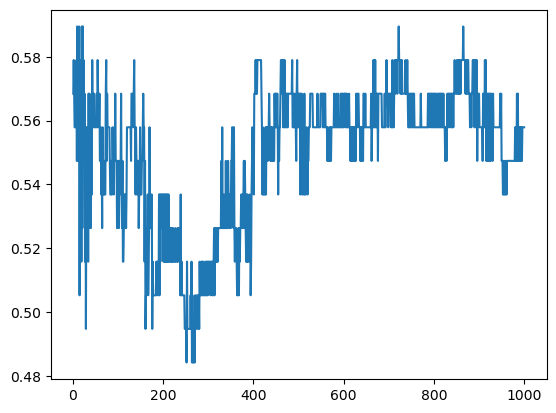

In [384]:

scores = list(adaboost_clf.staged_score(X_validation, Y_validation_classes))
iterations = range(1, len(scores) + 1)
plt.figure()
plt.plot(iterations, scores)

In [ ]:
adaboost_clf.predict_proba(X_validation)

array([[0.51000182, 0.48999818],
       [0.54943818, 0.45056182],
       [0.49598636, 0.50401364],
       [0.50215771, 0.49784229],
       [0.50819963, 0.49180037],
       [0.51158298, 0.48841702],
       [0.49904601, 0.50095399],
       [0.50669877, 0.49330123],
       [0.49800657, 0.50199343],
       [0.49251681, 0.50748319],
       [0.47417736, 0.52582264],
       [0.50079568, 0.49920432],
       [0.50590451, 0.49409549],
       [0.50166593, 0.49833407],
       [0.49671989, 0.50328011],
       [0.49943029, 0.50056971],
       [0.50564823, 0.49435177],
       [0.50028455, 0.49971545],
       [0.47705339, 0.52294661],
       [0.46663329, 0.53336671],
       [0.51045951, 0.48954049],
       [0.50195511, 0.49804489],
       [0.49899446, 0.50100554],
       [0.50255886, 0.49744114],
       [0.50324261, 0.49675739],
       [0.46988014, 0.53011986],
       [0.50483575, 0.49516425],
       [0.50680195, 0.49319805],
       [0.50483575, 0.49516425],
       [0.50147185, 0.49852815],
       [0.

#### K-fold cross-validation

In [426]:

print(adaboost_cv_clf.score(X_validation, Y_validation_classes))


0.5368421052631579


In [427]:

adaboost_cv_clf_conf_matrix = confusion_matrix(Y_validation_classes, adaboost_cv_clf.predict(X_validation))
print("Confusion Matrix:\n", adaboost_cv_clf_conf_matrix)

# Classification Report
adaboost_cv_clf_class_report = classification_report(Y_validation_classes, adaboost_cv_clf.predict(X_validation))
print("\nClassification Report:\n", adaboost_cv_clf_class_report)

Confusion Matrix:
 [[36 19]
 [25 15]]

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.65      0.62        55
           1       0.44      0.38      0.41        40

    accuracy                           0.54        95
   macro avg       0.52      0.51      0.51        95
weighted avg       0.53      0.54      0.53        95



### Gradient Boosting

In [368]:
print(gradboost_clf.score(X_validation, Y_validation_classes))

0.5473684210526316


In [365]:
gradboost_clf_conf_matrix = confusion_matrix(Y_validation_classes, gradboost_clf.predict(X_validation))
print("Confusion Matrix:\n", gradboost_clf_conf_matrix)


# Classification Report
gradboost_clf_class_report = classification_report(Y_validation_classes, gradboost_clf.predict(X_validation))
print("\nClassification Report:\n", gradboost_clf_class_report)

Confusion Matrix:
 [[33 22]
 [21 19]]

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.60      0.61        55
           1       0.46      0.47      0.47        40

    accuracy                           0.55        95
   macro avg       0.54      0.54      0.54        95
weighted avg       0.55      0.55      0.55        95



### Random Forest

In [388]:
print(randomforest_clf.score(X_validation, Y_validation_classes))

0.5789473684210527


In [376]:
randomforest_clf_conf_matrix = confusion_matrix(Y_validation_classes, randomforest_clf.predict(X_validation))
print("Confusion Matrix:\n", randomforest_clf_conf_matrix)


# Classification Report
randomforest_clf_class_report = classification_report(Y_validation_classes, randomforest_clf.predict(X_validation))
print("\nClassification Report:\n", randomforest_clf_class_report)

Confusion Matrix:
 [[39 16]
 [24 16]]

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.71      0.66        55
           1       0.50      0.40      0.44        40

    accuracy                           0.58        95
   macro avg       0.56      0.55      0.55        95
weighted avg       0.57      0.58      0.57        95



### Logistic regression classifier

In [361]:
Y_predict_classes = pipe.predict(X_validation)
pipe.score(X_validation, Y_validation_classes)

0.5578947368421052

In [349]:
# Confusion Matrix
conf_matrix = confusion_matrix(Y_validation_classes, Y_predict_classes)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(Y_validation_classes, Y_predict_classes)
print("\nClassification Report:\n", class_report)

Confusion Matrix:
 [[52  3]
 [39  1]]

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.95      0.71        55
           1       0.25      0.03      0.05        40

    accuracy                           0.56        95
   macro avg       0.41      0.49      0.38        95
weighted avg       0.44      0.56      0.43        95



### Decision Tree Regression

In [ ]:
dtr_pipe.score(X_validation, Y_validation)

-5.118719157814237

### Ridge regression

In [ ]:
ridge_pipe.score(X_validation, Y_validation)

-0.03949537172620965

## Scratch space for experimentation

In [ ]:
# display = DecisionBoundaryDisplay.from_estimator(
#     pipe, X_validation
# )

In [ ]:
def plot(x, y, theta, save_path, correction=1.0):
    """Plot dataset and fitted logistic regression parameters.

    Args:
        x: Matrix of training examples, one per row.
        y: Vector of labels in {0, 1}.
        theta: Vector of parameters for logistic regression model.
        save_path: Path to save the plot.
        correction: Correction factor to apply (Problem 2(e) only).
    """
    # Plot dataset
    plt.figure()
    plt.plot(x[y == 1, -2], x[y == 1, -1], "bx", linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], "go", linewidth=2)

    # Plot decision boundary (found by solving for theta^T x = 0)
    x1 = np.arange(min(x[:, -2]), max(x[:, -2]), 0.01)
    x2 = -(theta[0] / theta[2] * correction + theta[1] / theta[2] * x1)
    plt.plot(x1, x2, c="red", linewidth=2)

    # Add labels and save to disk
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.savefig(save_path)

0.07103605819788694 0.08712929970154071
0.4236547993389047 0.6458941130666561
0.02021839744032572 0.832619845547938
0.5680445610939323 0.925596638292661
0.4375872112626925 0.8917730007820798


Text(0, 0.5, 'Y')

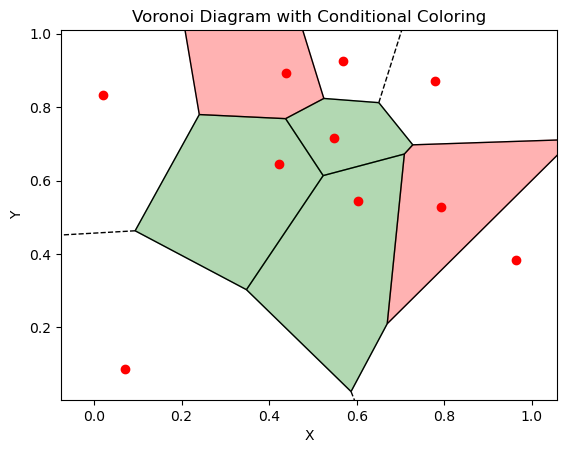

In [353]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np

# Generating random points
np.random.seed(0)
points = np.random.rand(10, 2)

# Creating Voronoi diagram
vor = Voronoi(points)

# Plotting Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=False)

# Plotting original points
plt.plot(points[:, 0], points[:, 1], 'ro')

# Check condition for each region
for region_index in vor.point_region:
    region = vor.regions[region_index]
    if -1 not in region:
        vertices = [vor.vertices[i] for i in region]
        x, y = points[region_index]
        print(x, y)
        if np.sin(30 * x * y) > 0:
            ax.fill(*zip(*vertices), color='green', alpha=0.3)
        else:
            ax.fill(*zip(*vertices), color='red', alpha=0.3)

plt.title('Voronoi Diagram with Conditional Coloring')
plt.xlabel('X')
plt.ylabel('Y')


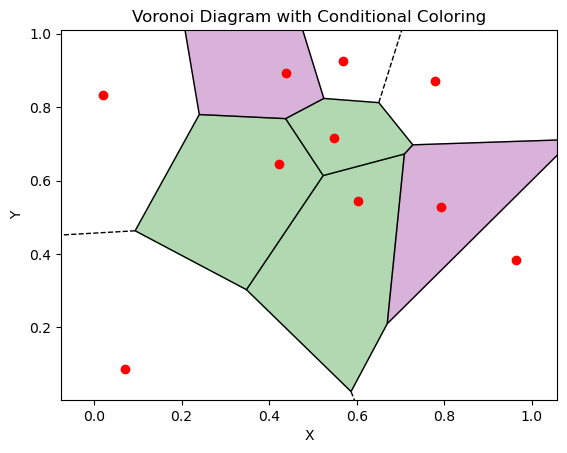

In [354]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np

# Generating random points
np.random.seed(0)
points = np.random.rand(10, 2)

# Creating Voronoi diagram
vor = Voronoi(points)

# Plotting Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=False)

# Plotting original points
plt.plot(points[:, 0], points[:, 1], 'ro')

# Check condition for each region
for region_index in vor.point_region:
    region = vor.regions[region_index]
    if -1 not in region:
        vertices = [vor.vertices[i] for i in region]
        outside = any(x < ax.get_xlim()[0] or x > ax.get_xlim()[1] or y < ax.get_ylim()[0] or y > ax.get_ylim()[1] for x, y in vertices)
        if outside:
            ax.fill(*zip(*vertices), color='purple', alpha=0.3)
        else:
            centroid = np.mean(vertices, axis=0)
            x, y = centroid
            if np.sin(x * y) > 0:
                ax.fill(*zip(*vertices), color='green', alpha=0.3)
            else:
                ax.fill(*zip(*vertices), color='red', alpha=0.3)

plt.title('Voronoi Diagram with Conditional Coloring')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
